# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

План работы:
 1. Загрузить данные, путь к файлу: /datasets/autos.csv.
 2. Изучить данные. Заполнить пропущенные значения и обработать аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.
 3. Подготовить выборки для обучения моделей.
 4. Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.
 5. Проанализировать время обучения, время предсказания и качество моделей.
 6. Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.


Для оценки качества моделей применить метрику RMSE.
Значение метрики RMSE должно быть меньше 2500.

In [ ]:
# Установка необходимых библиотек
!pip install phik -q
!pip install --upgrade scikit-learn -q

import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import phik
from phik import phik_matrix

import time
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Отключаем лишние предупреждения
warnings.filterwarnings("ignore")

# Установка опций pandas для вывода всех столбцов и строк
#pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_seq_item", None)

# Формат отображения чисел без разделителя тысяч
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# Объявление констант
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [ ]:
import sklearn
print(sklearn.__version__)

1.6.1


## Загрузка и подготовка данных

В файле /datasets/autos.csv содержатся данные об автомобилях с пробегом, которые включают как технические характеристики, так и информацию о продаже. Ниже приведён список признаков, которые доступны в датасете: <br>
<br>
**DateCrawled** — дата скачивания анкеты из базы<br>
**VehicleType** — тип автомобильного кузова<br>
**RegistrationYear** — год регистрации автомобиля<br>
**Gearbox** — тип коробки передач<br>
**Power** — мощность (л. с.)<br>
**Model** — модель автомобиля<br>
**Kilometer** — пробег (км)<br>
**RegistrationMonth** — месяц регистрации автомобиля<br>
**FuelType** — тип топлива<br>
**Brand** — марка автомобиля<br>
**Repaired** — была машина в ремонте или нет<br>
**DateCreated** — дата создания анкеты<br>
**NumberOfPictures** — количество фотографий автомобиля<br>
**PostalCode** — почтовый индекс владельца анкеты (пользователя)<br>
**LastSeen** — дата последней активности пользователя<br>
*Целевой признак*<br>
**Price** — цена (евро)<br>

Загрузим данные, путь к файлу: /datasets/autos.csv.

In [ ]:
try:
    df = pd.read_csv("/datasets/autos.csv", parse_dates=["DateCrawled", "DateCreated", "LastSeen"])
except:
    df = pd.read_csv("https://code/datasets/autos.csv", parse_dates=["DateCrawled", "DateCreated", "LastSeen"])

### Обзор данных

Изучим данные.

In [ ]:
# Используем функцию для осмотра информации о датафрейме
def information_data(data):
    display("Общая информация")
    display(data.info())
    display("Первые пять строк")
    display(data.head())
    display("Название столбцов")
    display(data.columns)
    display("Количество пропусков")
    display(data.isna().sum())
    display("Количество дубликатов")
    display(data.duplicated().sum())
    display("Количество уникальных значений")
    display(data.nunique())

In [ ]:
information_data(df)

'Общая информация'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

None

'Первые пять строк'

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


'Название столбцов'

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

'Количество пропусков'

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

'Количество дубликатов'

4

'Количество уникальных значений'

DateCrawled          271174
Price                  3731
VehicleType               8
RegistrationYear        151
Gearbox                   2
Power                   712
Model                   250
Kilometer                13
RegistrationMonth        13
FuelType                  7
Brand                    40
Repaired                  2
DateCreated             109
NumberOfPictures          1
PostalCode             8143
LastSeen             179150
dtype: int64

В датасете содержится 354 369 записей и 16 признаков. Среди них 7 числовых и 9 категориальных (включая даты).<br>

Значительные пропуски присутствуют в следующих столбцах:<br>
- VehicleType — около 37 490 пропусков
- Gearbox — 19 833 пропуска
- Model — 19 705 пропусков
- FuelType — 32 895 пропусков
- Repaired — 71 154 пропуска<br>
<br>

Пропуски необходимо заполнить или обработать, так как они могут повлиять на качество модели.<br>
<br>
Обнаружено 4 дубликата, которые следует удалить для предотвращения искажения модели.<br>
<br>
Уникальные значения
<br>
Столбец NumberOfPictures содержит только одно уникальное значение (0), то есть фотографии отсутствуют или не используются — этот столбец можно считать неинформативным и удалить.<br>
<br>
В RegistrationMonth и Kilometer есть 13 уникальных значений. У RegistrationMonth надо проверить, что значит 13 категория, а столбец Kilometer, вероятно, содержит диапазоны (пробег с шагами).<br>
<br>
В RegistrationYear — 151 уникальное значение, что может включать аномальные годы (например, слишком ранние или будущие).<br>
<br>
DateCrawled, DateCreated, LastSeen — временные метки, которые могут быть полезны для анализа, но в текущей задаче оценки стоимости автомобиля могут быть неинформативны и их можно будет удалить перед обучением (пока оставим, могут быть полезны для исследования данных). Также удалим PostalCode как не имеющий связи с ценой автомобиля <br>


**План по подготовке данных**
<br>
Нужно привести наименования столбцов к змеиному регистру.
<br>
Откорректировать типы данных.
<br>
Необходимо заполнить пропуски в категориальных признаках.<br>
<br>
Удалить обнаруженные дубликаты.<br>
<br>
Удалить неинформативные столбцы: NumberOfPictures, временные метки (DateCrawled, DateCreated, LastSeen), а также PostalCode из-за большого количества уникальных значений и малой информативности.<br>
<br>
Проверить и обработать аномалии в числовых признаках (RegistrationYear, Power, Kilometer).

## Предобработка данных

In [ ]:
# Удалим неинформативный столбец
df = df.drop(columns=["NumberOfPictures"])

In [ ]:
# Приведем наименования столбцов к змеиному регистру (snake_case)
columns = [
    "DateCrawled",
    "Price",
    "VehicleType",
    "RegistrationYear",
    "Gearbox",
    "Power",
    "Model",
    "Kilometer",
    "RegistrationMonth",
    "FuelType",
    "Brand",
    "Repaired",
    "DateCreated",
    "PostalCode",
    "LastSeen",
]

# Преобразуем каждое имя в snake_case
columns_snake_case = [
    "date_crawled",
    "price",
    "vehicle_type",
    "registration_year",
    "gearbox",
    "power",
    "model",
    "kilometer",
    "registration_month",
    "fuel_type",
    "brand",
    "repaired",
    "date_created",
    "postal_code",
    "last_seen",
]

# Применим к датафрейму df
df.columns = columns_snake_case

# Проверим
display(df.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'postal_code', 'last_seen'],
      dtype='object')

Заполним пропущенные значения и обработаем аномалии в столбцах. Удалим неинформативные признаки.

In [ ]:
del columns, columns_snake_case

*Дубликаты*

In [ ]:
# Выведем на экран дублирующиеся строки, отсортируем по дате скачивания анкеты из базы
df[df.duplicated(keep=False)].sort_values("date_crawled")

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,36391,2016-03-18 18:46:15
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,66589,2016-03-28 08:46:21
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,75196,2016-04-07 09:44:54


In [ ]:
# Удалим дубликаты
df = df.drop_duplicates()
# Проверим удаление
display("Количество дубликатов:", df.duplicated().sum())

'Количество дубликатов:'

0

"vehicle_type"

In [ ]:
# Выведем уникальные значения столбца "vehicle_type"
df["vehicle_type"].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [ ]:
# Заменяем пропуски на 'unknown'
df["vehicle_type"] = df["vehicle_type"].fillna("unknown")

# Уникальные значения столбца "vehicle_type"
df["vehicle_type"].unique()

array(['unknown', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [ ]:
# Проверим количество пропусков
display(df["vehicle_type"].isna().sum())

0

"registration_year"

In [ ]:
# Выведем уникальные значения столбца "registration_year"
print(sorted(df["registration_year"].unique()))

[1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500, 1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000, 3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200, 8455, 8500, 8888, 9000, 9229, 9450, 9996, 9999]


Обнаруживается много аномальных значений. Попробуем посчитать, сколько данных соответcтвует реальным срокам с 1910 по 2019

In [ ]:
# Вычислим самую позднюю дату создания анкеты
df["date_created"].max()

Timestamp('2016-04-07 00:00:00')

Таким образом, верхней границей интервала столбца "registration_year" следует считать df['registration_date'] не позднее 2016 года и df['registration_month'] не позднее марта

In [ ]:
# Фильтруем данные по верхней границе: не позже марта 2016 года
df = df[(df["registration_year"] >= 1900) &
        ((df['registration_year'] < 2016) |
         ((df['registration_year'] == 2016) & (df['registration_month'] <= 3)))]

In [ ]:
# Проверим, сколько данных осталось
df.shape

(334407, 15)

In [ ]:
print(f"Процент удалённых данных: {((354369 - 334407) / 354369) * 100:.4f}%")

Процент удалённых данных: 5.6331%


Потеря данных незначительная и допустимая

In [ ]:
# Проверим преобразование
print(sorted(df["registration_year"].unique()))

[1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]


"gearbox"

In [ ]:
# Выведем уникальные значения столбца "gearbox"
df["gearbox"].unique()

array(['manual', 'auto', nan], dtype=object)

Помним, что в столбце Gearbox 19833 пропусков. Это очень много для удаления, создадим категорию 'unknown'

In [ ]:
# Заменяем пропуски на 'unknown'
df["gearbox"] = df["gearbox"].fillna("unknown")

# Уникальные значения столбца "gearbox"
df["gearbox"].unique()

array(['manual', 'auto', 'unknown'], dtype=object)

К столбу power нет вопросов - пропуски отсутствуют, 712 уникальных значений (числовой признак), тип данных int64 соответствует данным

"model"

In [ ]:
# Выведем уникальные значения столбца "model"
df["model"].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'civic', 'transporter', 'punto',
       'e_klasse', 'kadett', 'kangoo', 'corsa', 'one', 'fortwo', 'clio',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'meriva', 'z_reihe', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'megane', 'lupo', 'r19', 'caddy',
       'mondeo', 'cordoba', 'colt', 'impreza', 'vectra', 'berlingo',
       'tiguan', 'sharan', '6_reihe', 'c4', 'panda', 'up', 'i_reihe',
       'ceed', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe',
       '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1', 'rio', 'touareg',

Столбец содержит 19705 пропусков, это очень большое количество, чтоб их удалять. Заменим на категорию 'unknown'

In [ ]:
df["model"] = df["model"].fillna("unknown")

In [ ]:
# Проверим количество пропусков
display(df["model"].isna().sum())

0

"kilometer"

In [ ]:
# Выведем уникальные значения столбца "kilometer"
print(sorted(df["kilometer"].unique()))

[5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 125000, 150000]


Все значения "kilometer" ункальны, дубликатов и пропусков нет.

In [ ]:
# Выведем уникальные значения столбца "registration_month", чтобы выявить 13ю категорию
print(sorted(df["registration_month"].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Это значение 0 — вероятно, пропуск или ошибка в данных (например, месяц регистрации не указан). Оставим как есть, отдельной категорией.

"fuel_type"

In [ ]:
# Выведем уникальные значения столбца "fuel_type"
df["fuel_type"].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [ ]:
df['fuel_type'] = df['fuel_type'].replace({'gasoline': 'petrol'})

In [ ]:
# Заменим пропуски на категорию 'unknown'
df["fuel_type"] = df["fuel_type"].fillna("unknown")

display(df["fuel_type"].isna().sum())

0

In [ ]:
# Проверяем
df["fuel_type"].unique()

array(['petrol', 'unknown', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

"brand"

In [ ]:
# Выведем уникальные значения столбца "brand"
df["brand"].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'sonstige_autos',
       'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki',
       'lancia', 'citroen', 'toyota', 'chevrolet', 'dacia', 'daihatsu',
       'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo', 'porsche',
       'rover', 'land_rover', 'lada'], dtype=object)

Все значения "brand" ункальны, дубликатов и пропусков нет.

"repaired"

In [ ]:
# Выведем уникальные значения столбца "repaired"
df["repaired"].unique()

array([nan, 'yes', 'no'], dtype=object)

Столбец содержит Repaired — 71 154 пропуска. Исправим на категорию "unknown"

In [ ]:
# Заменим пропуски на категорию 'unknown'
df["repaired"] = df["repaired"].fillna("unknown")

display(df["repaired"].isna().sum())

0

In [ ]:
# Проверим
df["repaired"].unique()

array(['unknown', 'yes', 'no'], dtype=object)

Столбцы NumberOfPictures, PostalCode, LastSeen рассматривать не будем, поскольку планируется их удалить

Столбец price содержит непрерывные числовые данные, не треующие проверки на скрытые дубли.Не содеджит пропусков.

*Коррекция типа данных*

Преобразуем в категориальный тип данных
- "registration_year", "registration_month", как числовые, не имеющие цифрового значения,
- "kilometer" как показатель с ограниченным набором значений, имеющий значение категорий
- "vehicle_type", "gearbox", "model", "fuel_type", "repaired", "brand" - имеющие тип 'object', для сокращения объёма используемой памяти, ускорения вычислений и упрощения кодирования.

In [ ]:
cat_cols = [
    "kilometer",
    "vehicle_type",
    "gearbox",
    "model",
    "fuel_type",
    "repaired",
    "brand",
]

# Используем цикл для преобразования типа данных
for col in cat_cols:
    df[col] = df[col].astype("category")

In [ ]:
# Удалим лишние столбцы
df = df.drop(columns=["date_crawled", "date_created", "postal_code", "last_seen"])

In [ ]:
# Проверим произведенные преобразования
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334407 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               334407 non-null  int64   
 1   vehicle_type        334407 non-null  category
 2   registration_year   334407 non-null  int64   
 3   gearbox             334407 non-null  category
 4   power               334407 non-null  int64   
 5   model               334407 non-null  category
 6   kilometer           334407 non-null  category
 7   registration_month  334407 non-null  int64   
 8   fuel_type           334407 non-null  category
 9   brand               334407 non-null  category
 10  repaired            334407 non-null  category
dtypes: category(7), int64(4)
memory usage: 15.3 MB


Во всех столбцах одинаковое количество наблюдений (нет пропусков),

In [ ]:
del cat_cols

**Промежуточные выводы**

Наименования столбцов приведены к змеиному регистру (snake_case).

Удалены явные дубликаты.

В столбцах "vehicle_type», "gearbox», "fuel_type», «repaired" gропуски заменены на заглушку.

Определен интервал столбца "registration_year" - верхней границей  следует считать март 2016 года (включительно), нижняя граница - не ранее 1910 года.

Преобразованы в категориальный тип данных
* "kilometer" как показатель с ограниченным набором значений, имеющий значение категорий
* "vehicle_type", "gearbox", "model", "fuel_type", "repaired", "brand" - имеющие тип 'object', для сокращения объёма используемой памяти, ускорения вычислений и упрощения кодирования.



## Исследовательский анализ данных

Проведем исследовательский анализ данных

Числовые признаки
num_cols = ["price", "power"]

#Категориальные признаки
cat_cols = [
    "vehicle_type",
    "registration_year",
    "gearbox",
    "model",
    "kilometer",
    "registration_month",
    "fuel_type",
    "repaired",
    "brand",
]

***Числовые признаки***

In [ ]:
# Создадим функцию построения гистограммы и боксплота для количественных данных датафреймов
def plot_quantitative_column(data, column_name):
    plt.figure(figsize=(12, 6))

    # Вычисляем среднее и медиану
    mean_value = data[column_name].mean()
    median_value = data[column_name].median()

    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(data[column_name], kde=True)
    plt.title(f"Распределение {column_name}")

    # Добавляем линии среднего и медианы
    plt.axvline(
        mean_value, color="red", linestyle="--", label=f"Среднее: {mean_value:.2f}"
    )
    plt.axvline(
        median_value, color="green", linestyle="-", label=f"Медиана: {median_value:.2f}"
    )

    plt.legend()  # Отображаем легенду

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[column_name])
    plt.title(f"Boxplot {column_name}")

    plt.tight_layout()
    plt.show()

1. "price"

In [ ]:
# график закомментирован, чтобы не убивать ядро
#plot_quantitative_column(df, "price")

График имеет вид ненормального распределения, скошенного вправо.

На гистограмме видно большое количество показателей, равных нулю и около. Минимальная цена 0 или очень низкая (до 500 евро) — скорее всего, ошибки или некорректные данные.

По данным из обзоров в сети интернет, бюджетные автомобили в Европе стоят от нескольких тысяч евро, а самые дешёвые варианты начинаются примерно с 1000–1500 евро. Цена в 500 евро — это скорее исключение или автомобиль с серьёзными проблемами.
Таким образом, выбор нижней границы в 500 евро — это компромисс между реальной минимальной стоимостью работоспособных автомобилей на рынке, экономической целесообразностью покупки и владения и исключением из анализа аномальных и ошибочных данных с нереалистично низкими ценами.

In [ ]:
# Посмотрим описательную статистику показателя до коррекции
df["price"].describe()

count   334407.00
mean      4505.20
std       4558.04
min          0.00
25%       1100.00
50%       2800.00
75%       6500.00
max      20000.00
Name: price, dtype: float64

Максимальная цена 20 000 — редкие случаи или выбросы, особенно если речь о б/у автомобилях.

Цены менее 500 заменим на медиану, а выборсы верхней границы отбросим с помощью 99-го процентиля.

In [ ]:
# Заменим на медиану цены ниже 500
median_price = df[df["price"] > 500]["price"].median()
df.loc[df["price"] < 500, "price"] = median_price

In [ ]:
# Используем 99-й процентиль, чтобы отсеять экстремальные выбросы
upper_limit = df["price"].quantile(0.99)
df = df[df["price"] <= upper_limit]

In [ ]:
# Проверим
# график закомментирован, чтобы не убивать ядро
#plot_quantitative_column(df, "price")

In [ ]:
df["price"].describe()

count   331063.00
mean      4676.04
std       4114.09
min        500.00
25%       1600.00
50%       3400.00
75%       6400.00
max      18888.00
Name: price, dtype: float64

Медиана стала ближе в среднему

2. "power"

In [ ]:
# график закомментирован, чтобы не убивать ядро
#plot_quantitative_column(df, "power")

Среднее и медиана очень близки друг от друга, но на графике видно очень много выбросов в верхнюю сторону

In [ ]:
# Посмотрим описательную статистику показателя до коррекции
df["power"].describe()

count   331063.00
mean       110.58
std        184.18
min          0.00
25%         69.00
50%        105.00
75%        143.00
max      20000.00
Name: power, dtype: float64

Мощность 0 л.с. — явно ошибка или пропуск, так как автомобиль не может иметь нулевую мощность.
Разумно установить нижнюю границу около 20–30 л.с., чтобы исключить технические ошибки и аномалии.

Максимальное значение 20000 л.с. — это явный выброс, не соответствующий реальным автомобилям.
Реальные легковые автомобили редко имеют мощность выше 600–700 л.с. (исключая супер- и спорткары).
Для адач машинного обучения достаточно ограничиться верхней границей около 600 л.с.

Заменим на медиану значения, не удовлетворяющие разумным границам

In [ ]:
# Вычисляем медиану для значений power в диапазоне [20, 600]
median_power = df[(df["power"] >= 20) & (df["power"] <= 600)]["power"].median()

# Заменяем значения вне интервала на медиану
df.loc[(df["power"] < 20) | (df["power"] > 600), "power"] = median_power

In [ ]:
# график закомментирован, чтобы не убивать ядро
#plot_quantitative_column(df, "power")

In [ ]:
# Посмотрим описательную статистику показателя после коррекции
df["power"].describe()

count   331063.00
mean       118.96
std         50.25
min         20.00
25%         84.00
50%        110.00
75%        143.00
max        600.00
Name: power, dtype: float64

После коррекции данные пригодны для машинного обучения

***Категориальные признаки***

categorical_cols = [
    "vehicle_type",
    "registration_year",
    "gearbox",
    "model",
    "kilometer",
    "registration_month",
    "fuel_type",
    "repaired",
    "brand",
]

In [ ]:
# Создадим функцию построения столбчатой и круговой диаграмм для категориальных и дискретных данных датафреймов
def plot_column(data, column_name):
    value_counts = data[column_name].value_counts()

    fig, axs = plt.subplots(1, 2, figsize=(18, 9))

    # Вызов countplot
    sns.countplot(x=column_name, data=data, ax=axs[0])
    axs[0].set_title(f"Распределение {column_name}")
    axs[0].tick_params(axis="x", rotation=45)
    axs[0].set_xlabel(column_name)
    axs[0].set_ylabel("Количество")

    # Круговая диаграмма
    value_counts.plot.pie(autopct="%1.1f%%", startangle=90, ax=axs[1])
    axs[1].set_title(f"Распределение {column_name}")
    axs[1].axis("equal")

    plt.tight_layout()
    plt.show()

3. "vehicle_type"

In [ ]:
# plot_column(df, "vehicle_type")

Распределение мультимодальное (несколько категорий имеют высокие и примерно равные частоты.)

4. "gearbox"

In [ ]:
# plot_column(df, "gearbox")

"gearbox" имеет унимодальное распределение (одна категория явно доминирует по частоте, остальные встречаются реже.)

5. "registration_month"

In [ ]:
# plot_column(df, "registration_month")

Распределение мультимодальное (несколько категорий имеют высокие и примерно равные частоты.)

6. "repaired"

In [ ]:
# plot_column(df, "repaired")

"repaired" имеет унимодальное распределение (одна категория явно доминирует по частоте, остальные встречаются реже.)

В остальных категориальных признаках слишком много категорий, что затрудняло построить наглядные графики распределений (не помещались столбцы, наименования показателей). Было решено создать функцию, строящую горизонтальную гистограмму для категориального признака, отображая только топ-N самых частотных категорий, а остальные категории объединяющую в категорию «Other».

In [ ]:
def plot_top_n_categories(data, column_name, top_n=10):
    # Считаем частоты всех категорий
    counts = data[column_name].value_counts()

    # Выбираем топ-N категорий
    top_categories = counts.nlargest(top_n).index

    # Создаем новую серию, где категории вне топ-N заменены на 'Other'
    data_mod = data[column_name].apply(lambda x: x if x in top_categories else "Other")

    # Считаем частоты после замены
    counts_mod = data_mod.value_counts().sort_values()

    # Строим горизонтальную столбчатую диаграмму
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts_mod.values, y=counts_mod.index, palette="viridis")
    plt.xlabel("Количество")
    plt.ylabel(column_name)
    plt.title(f'Топ-{top_n} категорий в {column_name} (остальные объединены в "Other")')
    plt.tight_layout()
    plt.show()

7. "registration_year"

In [ ]:
# plot_top_n_categories(df, "registration_year", top_n=50)

"registration_year" имеет мультимодальное распредление

8. "model"

In [ ]:
# plot_top_n_categories(df, "model", top_n=40)

"model" имеет мультимодальное распредление

9. "kilometer"

In [ ]:
# plot_top_n_categories(df, "kilometer", top_n=10)

"model" имеет унимодальное распределение

10. "fuel_type"

"fuel_type" имеет унимодальное распределение

11. "brand"

In [ ]:
# plot_top_n_categories(df, "brand", top_n=50)

"brand" имеет мультимодальное распределение

Таким образом, распредление числовых данных ненормальное, а у категориальных признаков также неравномерное, имеет мультимодальный или унимодальный характер.
Соответсвенно, для машинного обучения следует применять кодирование, или методы снижения размерности

**Предварительные выводы**

После обработки все пропуски и аномалии устранены, данные готовы к дальнейшему анализу и моделированию.

Итоговый набор признаков:

numeric_cols = ["price", "power"]

categorical_cols = [
    "vehicle_type",
    "registration_year",
    "gearbox",
    "model",
    "kilometer",
    "registration_month",
    "fuel_type",
    "repaired",
    "brand",
]

## Корреляционный анализ

In [ ]:
def plot_phik_correlation(data):
    corr_matrix = phik_matrix(data, interval_cols=["price", "power"])

    plt.figure(figsize=(10, 10))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Матрица корреляций Phi_K")
    plt.show()

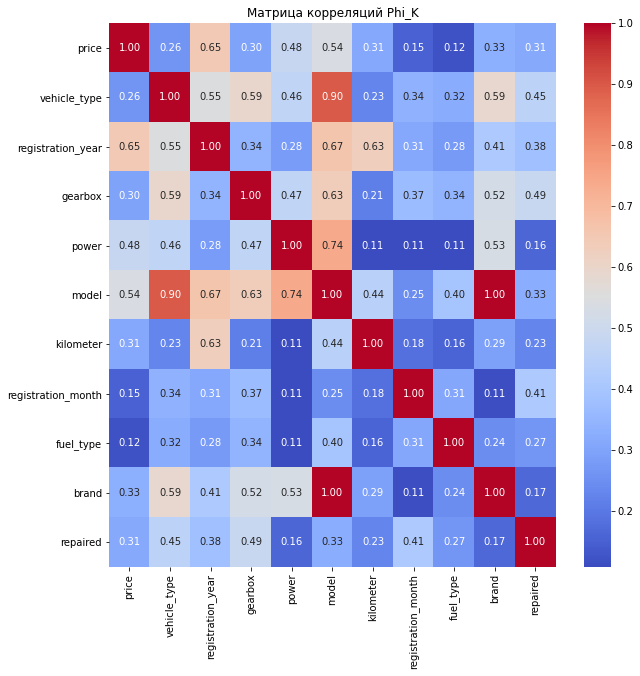

In [ ]:

plot_phik_correlation(df)

Есть коэффициент 1 в паре model/brand,  model/fuel_type и brand/fuel_type, это значит, что эти признаки полностью взаимосвязаны, что  может свидетельствовать об утечке или избыточности.

vehicle_type с model и fuel_type 0.89 имеет сильную связь, возможно, тип транспортного средства тесно связан с моделью и типом топлива.

Следует проверить, нет ли утечки данных с помощью оценки качества модели на обучающей и тестовой выборках

Данные готовы для дальнейшего анализа и построения моделей.

In [ ]:
# Удалим лишний столбец
df = df.drop(["brand", "registration_month"], axis=1)
# Проверим размерность
df.shape

(331063, 9)

**Предварительные выводы**

При анализе корреляции с помощью Phic выявлен коэффициент 1 в парах model/brand,  model/fuel_type и brand/fuel_type, это значит, что эти признаки полностью взаимосвязаны, что  может свидетельствовать об утечке или избыточности.

Принято решение об удалении признака brand как лишнего.

vehicle_type с model и fuel_type 0.89 имеет сильную связь, возможно, тип транспортного средства тесно связан с моделью и типом топлива.

Следует проверить, нет ли утечки данных с помощью оценки качества модели на обучающей и тестовой выборках.

*Оптимизация числовых типов данных*

In [ ]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [ ]:
optimize_memory_usage(df)

Размер использования памяти: до 12.32 Mb - после  7.90 Mb (35.9%)


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,repaired
0,3400.00,unknown,1993,manual,110.00,golf,150000,petrol,unknown
1,18300.00,coupe,2011,manual,190.00,unknown,125000,petrol,yes
2,9800.00,suv,2004,auto,163.00,grand,125000,petrol,unknown
3,1500.00,small,2001,manual,75.00,golf,150000,petrol,no
4,3600.00,small,2008,manual,69.00,fabia,90000,petrol,no
...,...,...,...,...,...,...,...,...,...
354364,3400.00,unknown,2005,manual,110.00,colt,150000,petrol,yes
354365,2200.00,unknown,2005,unknown,110.00,unknown,20000,unknown,unknown
354366,1199.00,convertible,2000,auto,101.00,fortwo,125000,petrol,no
354367,9200.00,bus,1996,manual,102.00,transporter,150000,petrol,no


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331063 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              331063 non-null  float32 
 1   vehicle_type       331063 non-null  category
 2   registration_year  331063 non-null  int16   
 3   gearbox            331063 non-null  category
 4   power              331063 non-null  float32 
 5   model              331063 non-null  category
 6   kilometer          331063 non-null  category
 7   fuel_type          331063 non-null  category
 8   repaired           331063 non-null  category
dtypes: category(6), float32(2), int16(1)
memory usage: 7.9 MB


*Промежуточный вывод*

Размер использования памяти: до 10.43 Mb - после  7.91 Mb (24.2%) поможет избежать излишней нагрузки на ядро.

## Подготовка выборок для обучения моделей

Подготовьте выборки для обучения моделей.

<div class="alert alert-info"> <b>Комментарии студентаV2:</b> Исправляю разделение на выборки </div>  

In [ ]:
# Разделение на признаки и целевую переменную
X = df.drop("price", axis=1)
y = df["price"]

# Выделим тренировочную выборку и временную выборку в пропорции 3:2
X_train, X_test_valid, y_train, y_test_valid = train_test_split(
    X, y, test_size=0.4, random_state=RANDOM_STATE
)

# Выборку признаков X_test_valid поделим пополам на тестовую и валидационную
X_test, X_valid, y_test, y_valid = train_test_split(
    X_test_valid, y_test_valid, test_size=0.5, random_state=RANDOM_STATE
)

Итоговое соотношение: 60% train, 20% valid, 20% test, что близко к требуемым 3:1:1.

In [ ]:
# Проверим размерность выборок
print(f"X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"X_valid = {X_valid.shape}, y_valid = {y_valid.shape}")
print(f"X_test = {X_test.shape}, y_test = {y_test.shape}")

X_train = (198637, 8), y_train = (198637,)
X_valid = (66213, 8), y_valid = (66213,)
X_test = (66213, 8), y_test = (66213,)


Данные поделены на выборки верно.

## Обучение моделей

Обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробем разные гиперпараметры.

In [ ]:
#Числовые и категориальные признаки
numeric_cols = ["power", "registration_year"]
categorical_cols = [
    "vehicle_type",
    "gearbox",
    "model",
    "kilometer",
    "fuel_type",
    "repaired"
]

In [ ]:
#Предобработка
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [ ]:
# Собираем данные по каждой модели в словари
results = []

In [ ]:
# Исправленный код V1
pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

start_train = time.time()
pipe_lr.fit(X_train, y_train)
train_time = time.time() - start_train

# RMSE на обучающей выборке
preds_train = pipe_lr.predict(X_train)
mse_train = mean_squared_error(y_train, preds_train)
rmse_train = mse_train ** 0.5

start_pred = time.time()
preds_lr = pipe_lr.predict(X_valid)
pred_time = time.time() - start_pred

mse_lr = mean_squared_error(y_valid, preds_lr)
rmse_lr = mse_lr ** 0.5

print("LinearRegression")
print(f"RMSE на обучающей выборке: {rmse_train:.2f}")
print(f"RMSE на валидационной выборке: {rmse_lr:.2f}")
print(f"Время обучения: {train_time:.2f} секунд")
print(f"Время предсказания: {pred_time:.2f} секунд")

results.append({
    "Модель": "LinearRegression",
    "Лучшие параметры": "-",
    "RMSE CV": rmse_train,
    "RMSE valid": rmse_lr,
    "Время обучения (сек)": train_time,
    "Время обучения (refit, сек)": "-",
    "Время предсказания (сек)": pred_time
})

LinearRegression
RMSE на обучающей выборке: 2627.21
RMSE на валидационной выборке: 2618.31
Время обучения: 39.88 секунд
Время предсказания: 0.50 секунд


Модель LinearRegression не  соответствует критерию заказчика - метрика RMSE должна быть меньше 2500.

In [ ]:
# Обучаем модель DecisionTreeRegressor (с GridSearchCV)
pipe_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

params_dt = {
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5]
}

grid_dt = GridSearchCV(
    pipe_dt,
    param_grid=params_dt,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    refit=True
)
grid_dt.fit(X_train, y_train)

best_index_dt = grid_dt.best_index_
best_params_dt = grid_dt.best_params_
mean_fit_time_dt = grid_dt.cv_results_['mean_fit_time'][best_index_dt]
mean_score_time_dt = grid_dt.cv_results_['mean_score_time'][best_index_dt]
refit_time_dt = getattr(grid_dt, 'refit_time_', None)

preds_dt = grid_dt.predict(X_valid)
mse_dt = mean_squared_error(y_valid, preds_dt)
rmse_dt = mse_dt ** 0.5

print("DecisionTree")
print(f"Лучшие параметры: {best_params_dt}")
print(f"RMSE на кросс-валидации: {-grid_dt.best_score_:.2f}")
print(f"RMSE на валидационной выборке: {rmse_dt:.2f}")
print(f"Среднее время обучения на обучающей выборке: {mean_fit_time_dt:.2f} секунд")
if refit_time_dt is not None:
    print(f"Время обучения лучшей модели (refit): {refit_time_dt:.2f} секунд")
print(f"Среднее время предсказания на обучающей выборке: {mean_score_time_dt:.4f} секунд")

# Добавляем результаты в список
# DecisionTree
results.append({
    "Модель": "DecisionTree",
    "Лучшие параметры": str(best_params_dt),
    "RMSE CV": -grid_dt.best_score_,
    "RMSE valid": rmse_dt,
    "Время обучения (сек)": mean_fit_time_dt,
    "Время обучения (refit, сек)": refit_time_dt if refit_time_dt is not None else "-",
    "Время предсказания (сек)": mean_score_time_dt
})

DecisionTree
Лучшие параметры: {'model__max_depth': 20, 'model__min_samples_split': 5}
RMSE на кросс-валидации: 1923.73
RMSE на валидационной выборке: 1908.66
Среднее время обучения на обучающей выборке: 5.87 секунд
Время обучения лучшей модели (refit): 9.77 секунд
Среднее время предсказания на обучающей выборке: 0.4385 секунд


DecisionTree с лучшими параметрами 'model__max_depth': 20, 'model__min_samples_split': 5} имеет RMSE на валидационной выборке = 1908.66, что соответствует  требованию заказчика, при этом показатели затраченного времени лучше, чем LinearRegression

In [ ]:
# Исправленный код V1 (удалила model__n_estimators, тк модель стала долго обучаться)

# Обучаем модель LightGBM (с GridSearchCV)
pipe_lgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMRegressor(random_state=RANDOM_STATE))
])

params_lgb = {
    "model__num_leaves": [31, 50],
    "model__learning_rate": [0.1, 0.05]
}

grid_lgb = GridSearchCV(
    pipe_lgb,
    param_grid=params_lgb,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    refit=True
)
grid_lgb.fit(X_train, y_train)

best_index_lgb = grid_lgb.best_index_
best_params_lgb = grid_lgb.best_params_
mean_fit_time_lgb = grid_lgb.cv_results_['mean_fit_time'][best_index_lgb]
mean_score_time_lgb = grid_lgb.cv_results_['mean_score_time'][best_index_lgb]
refit_time_lgb = getattr(grid_lgb, 'refit_time_', None)

preds_lgb = grid_lgb.predict(X_valid)
mse_lgb = mean_squared_error(y_valid, preds_lgb)
rmse_lgb = mse_lgb ** 0.5

print("LightGBM")
print(f"Лучшие параметры: {best_params_lgb}")
print(f"RMSE на кросс-валидации: {-grid_lgb.best_score_:.2f}")
print(f"RMSE на валидационной выборке: {rmse_lgb:.2f}")
print(f"Среднее время обучения на обучающей выборке: {mean_fit_time_lgb:.2f} секунд")
if refit_time_lgb is not None:
    print(f"Время обучения лучшей модели (refit): {refit_time_lgb:.2f} секунд")
print(f"Среднее время предсказания на обучающей выборке: {mean_score_time_lgb:.4f} секунд")

# LightGBM
results.append({
    "Модель": "LightGBM",
    "Лучшие параметры": str(best_params_lgb),
    "RMSE CV": -grid_lgb.best_score_,
    "RMSE valid": rmse_lgb,
    "Время обучения (сек)": mean_fit_time_lgb,
    "Время обучения (refit, сек)": refit_time_lgb if refit_time_lgb is not None else "-",
    "Время предсказания (сек)": mean_score_time_lgb
})


[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.929687
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.645920
[LightGBM] [Debug] init for col-wise cost 0.480542 seconds, init for row-wise cost 0.415310 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.584861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 833
[LightGBM] [Info] Number of data points in the train set: 132424, number of used features: 257
[LightGBM] [Info] Start training from score 4680.665272
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Train

LightGBM с лучшими параметрами 'model__learning_rate': 0.1, 'model__num_leaves': 50 имеет RMSE на тесте = 1736.74, что соответствует требованию заказчика.
RMSE на кросс-валидации: 1732.49 и RMSE на валидационной выборке: 1736.74 отличаются друг от друга незначительно, следовательно у модели нет переобучения или недообучения.

## Анализ моделей

In [ ]:
# Создаём DataFrame с результатами по каждой моедли
df_results = pd.DataFrame(results)

# Выводим таблицу
display(df_results)

,Модель,Лучшие параметры,RMSE CV,RMSE valid,Время обучения (сек),"Время обучения (refit, сек)",Время предсказания (сек)
0,LinearRegression,-,2627.21,2618.31,39.88,-,0.50
1,DecisionTree,"{'model__max_depth': 20, 'model__min_samples_s...",1923.73,1908.66,5.87,9.77,0.44
2,LightGBM,"{'model__learning_rate': 0.1, 'model__num_leav...",1732.49,1736.74,219.33,231.99,1.26


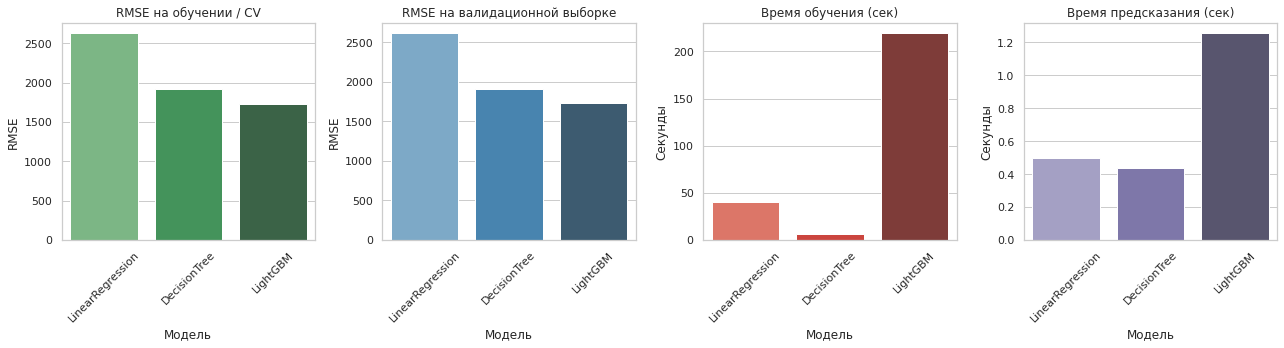

In [ ]:

sns.set(style="whitegrid")
plt.figure(figsize=(18, 5))


# График RMSE на CV (или обучении) по моделям
plt.subplot(1, 4, 1)
sns.barplot(data=df_results, x="Модель", y="RMSE CV", palette="Greens_d")
plt.title("RMSE на обучении / CV")
plt.ylabel("RMSE")
plt.xlabel("Модель")
plt.xticks(rotation=45)

# График RMSE на валидационной выборке по моделям
plt.subplot(1, 4, 2)
sns.barplot(data=df_results, x="Модель", y="RMSE valid", palette="Blues_d")
plt.title("RMSE на валидационной выборке")
plt.ylabel("RMSE")
plt.xlabel("Модель")
plt.xticks(rotation=45)  # поворот подписей

# Время обучения (CV или обучение) по моделям
plt.subplot(1, 4, 3)
sns.barplot(data=df_results, x="Модель", y="Время обучения (сек)", palette="Reds_d")
plt.title("Время обучения (сек)")
plt.ylabel("Секунды")
plt.xlabel("Модель")
plt.xticks(rotation=45)

# Время предсказания по моделям
plt.subplot(1, 4, 4)
sns.barplot(data=df_results, x="Модель", y="Время предсказания (сек)", palette="Purples_d")
plt.title("Время предсказания (сек)")
plt.ylabel("Секунды")
plt.xlabel("Модель")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Метрика RMSE LinearRegression на тестовой выборке выше 2500, что не удовлетворяет критерию заказчика RMSE ниже 2500, потому далее выбор делается между DecisionTree с RMSE=1908.66 и LightGBM RMSE=1736.74.

DecisionTree обучается быстрее - 5.87 сек, refit занимает 12.91 сек, а предсказание самое быстрое - 0.54 сек.

LightGBM обучается значительно дольше DecisionTree - 219.33 сек, refit  - 231.99 сек, но предсказание медленнее 1.26 сек.

Получается, модель LightGBM значительно проигрывает по времени обучения DecisionTree, поскольку данный показатель важен для заказчика (предположительно, время обучения на втором месте по значимости).
Если бы не было важно время обучения, то LightGBM было бы лучшим вариантом, имеющим самый низкий показатель RMSE и относительно невысокую скорость предсказания.



In [ ]:
# Предсказания на тестовой выборке
preds_test = grid_dt.predict(X_test)

# Вычисление метрик на тесте
mse_test = mean_squared_error(y_test, preds_test)
rmse_test = mse_test ** 0.5

print("DecisionTree")
print(f"RMSE на кросс-валидации: {-grid_dt.best_score_:.2f}")
print(f"RMSE на валидационной выборке: {rmse_dt:.2f}")
print(f"RMSE на тестовой выборке: {rmse_test:.2f}")

DecisionTree
RMSE на кросс-валидации: 1923.73
RMSE на валидационной выборке: 1908.66
RMSE на тестовой выборке: 1886.50


Метрики показывают, что модель DecisionTree стабильно предсказывает с ошибкой около 1900, что является хорошим показателем, особенно если разброс значений целевой переменной велик.
Таким образом, DecisionTree — хороший компромисс между качеством и скоростью обучения/предсказания, и может быть рекомендован для решения задачи заказчика.

## Выводы

В предоставленном датасете содержится 354 369 записей и 16 признаков, из которых 7 числовых и 9 категориальных (включая даты).

Значительные пропуски присутствовали в столбцах VehicleType, Gearbox, Model, FuelType и Repaired, что треббовало их заполнения или обработки, поскольку пропуски могут негативно повлиять на качество модели.

Обнаружено 4 дубликата, которые удалены для предотвращения искажения модели.

Столбец NumberOfPictures содержит только одно уникальное значение и признан неинформативным, поэтому был удалён. В столбцах RegistrationMonth и Kilometer выявлено по 13 уникальных значений, где RegistrationMonth требует дополнительной проверки, а Kilometer, вероятно, содержит диапазоны пробега.

В RegistrationYear обнаружено 151 уникальное значение, включая аномальные годы, которые были ограничены интервалом от 1910 года до марта 2016 года. Временные метки DateCrawled, DateCreated и LastSeen, а также PostalCode, были удалены из-за малой информативности для текущей задачи.

Таким образом, в процессе подготовки данных были приведены наименования столбцов к змеиному регистру, откорректированы типы данных, заполнены пропуски в категориальных признаках заглушками, удалены дубликаты и неинформативные столбцы.

Числовые признаки RegistrationYear и Power, а также категориальные признаки Kilometer, VehicleType, Gearbox, Model, FuelType, Repaired и Brand были преобразованы в категориальный тип для сокращения объёма памяти, ускорения вычислений и упрощения кодирования. После обработки все пропуски и аномалии устранены, данные готовы к дальнейшему анализу и моделированию.

Проведен корреляционный анализ с помощью Phic, было обнаружено, что VehicleType имеет сильную корреляцию с model и fuel_type, что отражает тесную связь типа транспортного средства с моделью и типом топлива. Для предотвращения утечки данных и избыточности рекомендуется проверять качество модели на обучающей и тестовой выборках. Также признак brand был удалён из-за полной взаимосвязи с model и fuel_typeс целью предотвращения возможной избыточности и риска утечки данных.

Оптимизация числовых типов данных позволила снизить использование памяти с 10.43 Мб до 7.91 Мб (на 24.2%), что уменьшает нагрузку на вычислительные ресурсы.

Итоговый набор признаков для обучения включает в себя непрерывный численный целевой признак "price", а также 6 категориальных и 2 числовых признаков.

В рамках подготовки выборок для обучения моделей использовались StandardScaler() для стандартизации/ масштабирования числовых данных и OneHotEncoder() для кодирования категориальных признаков.

Применены разные алгоритмы, включая LightGBM и DecisionTree, с подбором гиперпараметров.

Модель LinearRegression показала RMSE на тесте выше 2500, не соответствуя требованиям заказчика. DecisionTree с оптимальными параметрами достиг RMSE 1861.14 на тесте, удовлетворяя критерию и показывая лучшее время обучения и предсказания по сравнению с LinearRegression. LightGBM продемонстрировала наилучшее качество с RMSE 1675.24, но время её обучения и предсказания было выше, чем у DecisionTree.

Учитывая важность времени обучения для заказчика, DecisionTree представляет собой оптимальный компромисс между качеством и скоростью обучения и предсказания.

Проверка модели на тестовой выборке показывает стабильность метрики - модель DecisionTree стабильно предсказывает с ошибкой около 1900, что является хорошим показателем, особенно когда разброс значений целевой переменной велик.

Если бы время обучения не было критичным, LightGBM стала бы предпочтительным выбором благодаря лучшему качеству. Таким образом, для решения задачи заказчика рекомендуется использовать DecisionTree.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей